# Vehicle detection and tracking
## Pipeline summary
* Each frame of video, run a search for cars using a sliding window technique
* Wherever classifier returns a positive detection, record the position of the window that the detection was made
* For overlapping detections, assign the position of the detection to the centroid of the overlapping windows
* For false positives, filter out by detecting them as transients from one frame to the next
* Once a high confidence detection has been reached, record how the centroid moves from one frame to the next and predict centroids in subsequent frames

## Project tips
* Decide what features to use
 * Try combination of colour and gradient
 * Experiment
* Choose and train a classifer
 * Linear SVM for speed/accuracy
* Implement sliding window on test images
 * Try multi-scale search or different tiling schemes
 * Try to minimise number of search windows (ie ignore sky)
* With a working detection pipeline, move to video streams
 * Implement tracking and filter out spurious detections 

## Imports

In [1]:
import glob
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage import exposure
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

from helper import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from vehicle_tracking import Vehicle, VehicleTracking

In [3]:
images = glob.glob('test_images/*vehicles/*/*png')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

data_info = data_look(cars, notcars)

print('There are', data_info["n_cars"], 'car examples')
print('There are', data_info["n_notcars"], 'notcar examples')
print('Each image is of type', data_info["data_type"], 'with shape', data_info["image_shape"])

There are 8792 car examples
There are 8968 notcar examples
Each image is of type float32 with shape (64, 64, 3)


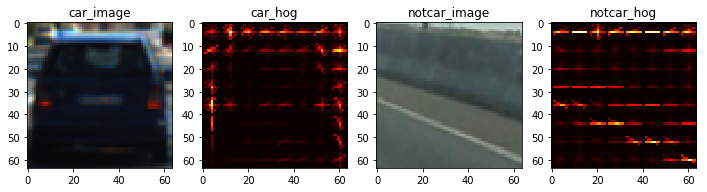

In [62]:
# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
spatial_params = {
    'conv'      : None,
    'size'      : (16, 16)
}

hoc_params = {
    'conv'        : None,
    'bins'        : 16
}

hog_params = {
    'conv'           : None,
    'channels'       : [0],
    'orientations'   : 6,
    'pix_per_cell'   : 8,
    'cell_per_block' : 2
}

car_features, car_hog = extract_features_single(car_image, True,
                                                spatial_params, hoc_params, hog_params)
notcar_features, notcar_hog = extract_features_single(notcar_image, True,
                                                      spatial_params, hoc_params, hog_params)

images = [car_image, car_hog, notcar_image, notcar_hog]
titles = ['car_image', 'car_hog', 'notcar_image', 'notcar_hog']
fig = plt.figure(figsize=(12,3))
visualise(fig, 1, 4, images, titles)

In [ ]:
col_features = color_hist(car_image, hoc_params)
bin_features = bin_spatial(car_image, spatial_params)



In [5]:
# Define feature parameters
colour_space = 'RGB2YCrCb'

spatial_params = {
    'conv'      : colour_space,
    'size'      : (32, 32)
}

hoc_params = {
    'conv'        : colour_space,
    'bins'        : 32
}

hog_params = {
    'conv'           : colour_space,
    'channels'       : [0, 1, 2],
    'orientations'   : 9,
    'pix_per_cell'   : 8,
    'cell_per_block' : 2
}

t=time.time()
n_samples = None #1000
if n_samples is not None:
    random_idxs = np.random.randint(0, len(cars), n_samples)
    test_cars = np.array(cars)[random_idxs]
    test_notcars = np.array(notcars)[random_idxs]
else:
    test_cars = cars
    test_notcars = notcars

car_features = extract_features(test_cars, spatial_params, hoc_params, hog_params)
notcar_features = extract_features(test_notcars, spatial_params, hoc_params, hog_params)
print(time.time()-t, 'seconds to compute features')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Spatial params:',spatial_params['size'],'spatial sampling size')
print('HOC params:',hoc_params['bins'],'histogram bins')
print('HOG params:',hog_params['orientations'],'orientations',
      hog_params['pix_per_cell'],'pixels per cell and',
      hog_params['cell_per_block'],'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'seconds to train SVC')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

113.29119801521301 seconds to compute features
Spatial params: (32, 32) spatial sampling size
HOC params: 32 histogram bins
HOG params: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
8.47 seconds to train SVC
Test Accuracy of SVC =  0.9921


1.174689531326294 seconds to process one image searching 157 windows


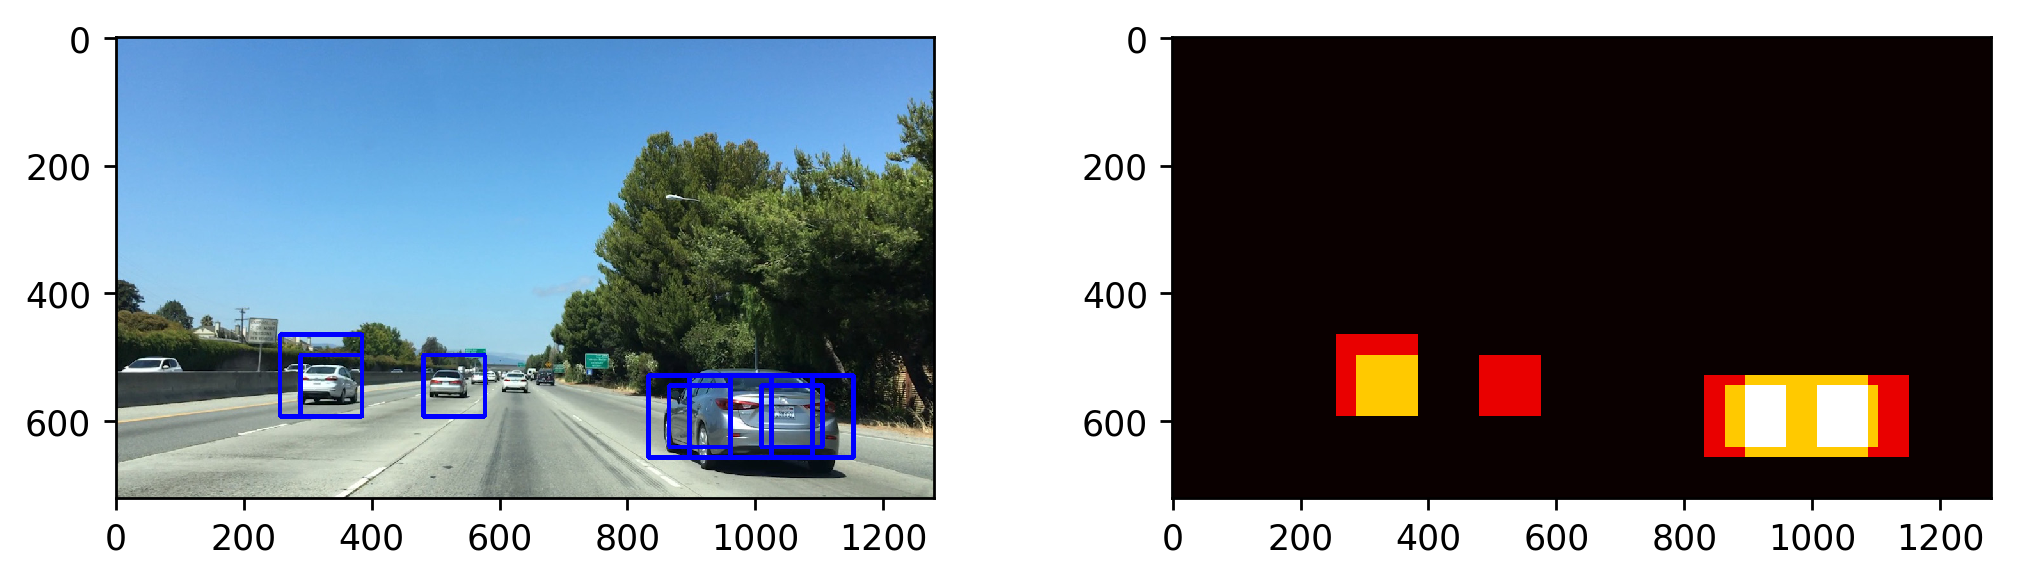

In [6]:
example_images = glob.glob('test_images/*jpg')
images=[]
titles=[]

y_start_stop=(400,656)
overlap=0.5

for img_src in example_images:
    t=time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    windows1 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=(96,96), xy_overlap=(overlap, overlap))
    windows2 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=(128,128), xy_overlap=(overlap, overlap))
    windows = windows1 + windows2

    hot_windows = search_windows(img, windows, svc, X_scaler, spatial_params,
                                 hoc_params, hog_params)
    
    heatmap = add_heat(heatmap, hot_windows)

    window_img = draw_boxes(draw_img, hot_windows)
    images.append(window_img)
    titles.append('')
    images.append(heatmap)
    titles.append('')
    print(time.time()-t, 'seconds to process one image searching', len(windows), 'windows')
    break

fig = plt.figure(figsize=(10,20), dpi=250)
visualise(fig, 7, 2, images, titles)

2.2560529708862305 seconds to process one image searching 350 windows


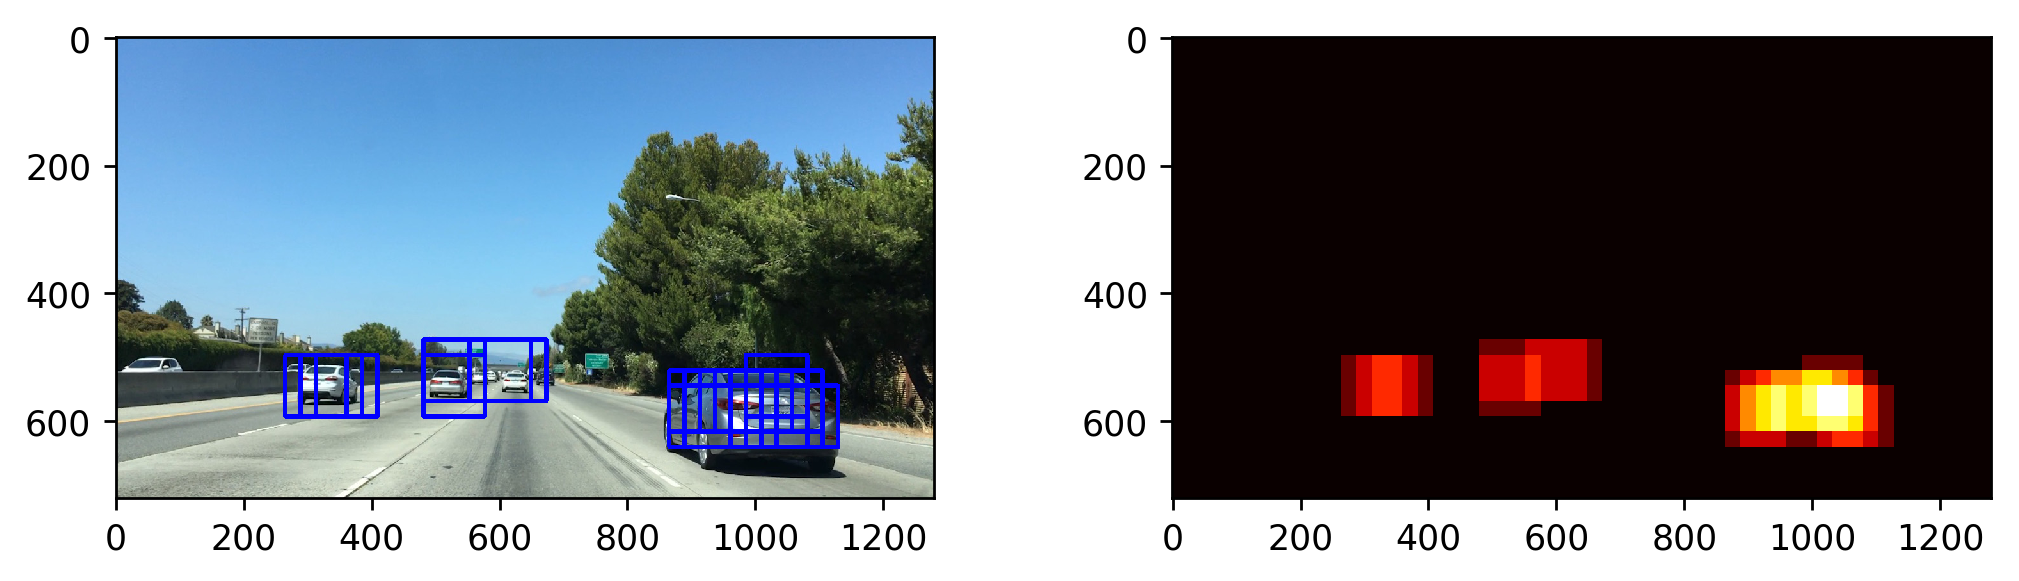

In [7]:
example_images = glob.glob('test_images/*jpg')
images=[]
titles=[]

ystart = 400
ystop = 656
scale=1.5

for img_src in example_images:
    t=time.time()
    img = mpimg.imread(img_src)

    draw_img, heatmap, count = find_cars(img, ystart, ystop, scale,
                                  svc, X_scaler, spatial_params, hoc_params, hog_params)
    
    images.append(draw_img)
    titles.append('')
    images.append(heatmap)
    titles.append('')
    print(time.time()-t, 'seconds to process one image searching', count, 'windows')
    break

fig = plt.figure(figsize=(10,20), dpi=250)
visualise(fig, 7, 2, images, titles)

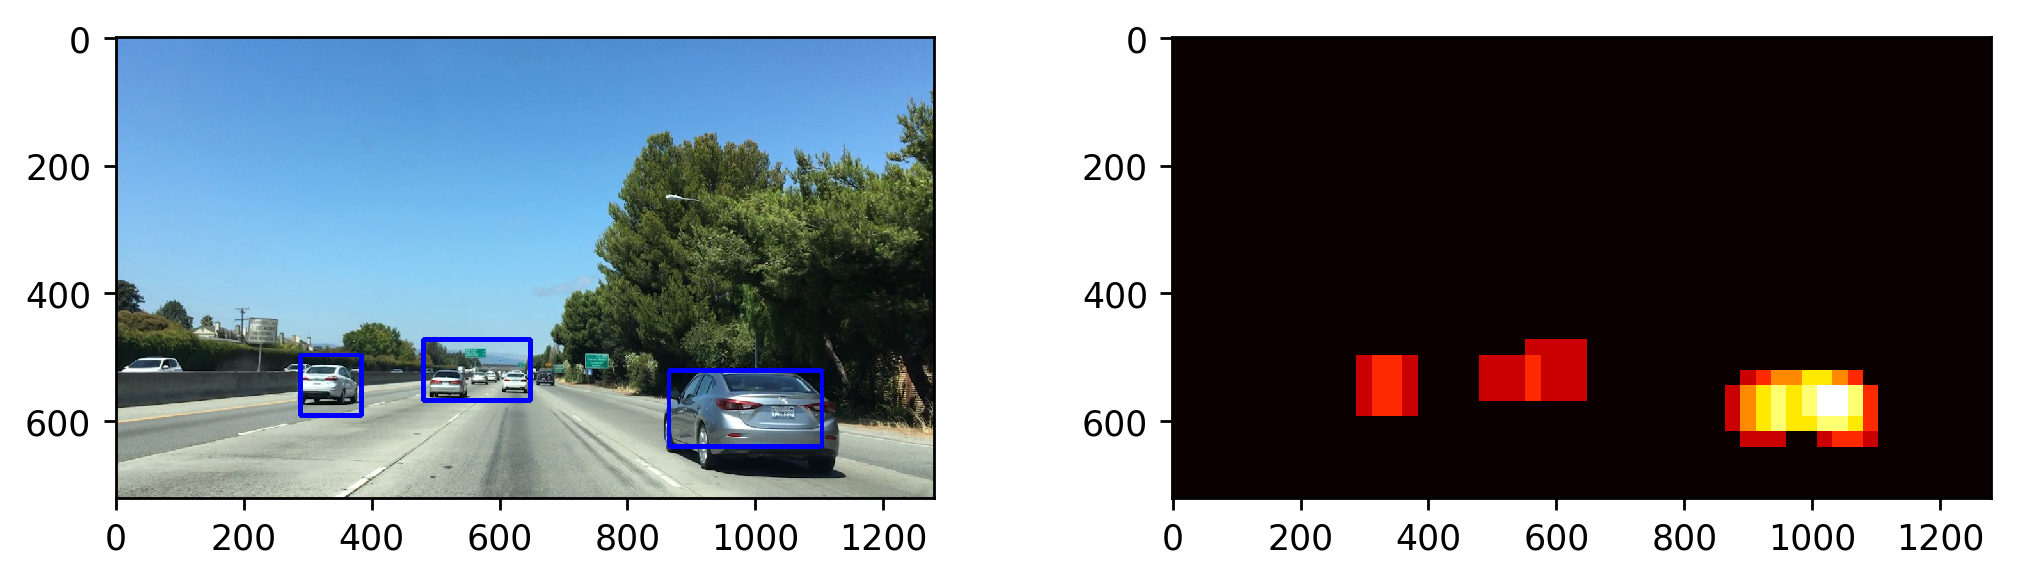

In [8]:
example_images = glob.glob('test_images/*jpg')
images=[]
titles=[]

ystart = 400
ystop = 656
scale=1.5

for img_src in example_images:
    img = mpimg.imread(img_src)
    draw_img, heatmap, count = find_cars(img, ystart, ystop, scale,
                                  svc, X_scaler, spatial_params, hoc_params, hog_params)
    heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    labeled_img = draw_labeled_bboxes(np.copy(img), labels)
    images.append(labeled_img)
    titles.append('')
    images.append(heatmap)
    titles.append('')
    break

fig = plt.figure(figsize=(10,20), dpi=250)
visualise(fig, 7, 2, images, titles)

In [9]:
def simple_process_image(img):
    out_img, heatmap, count = find_cars(img, ystart, ystop, scale,
                                  svc, X_scaler, spatial_params, hoc_params, hog_params)
    heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

Found 20 windows. Found 3 cars. 
Adding new vehicle object.
Adding new vehicle object.
Adding new vehicle object.

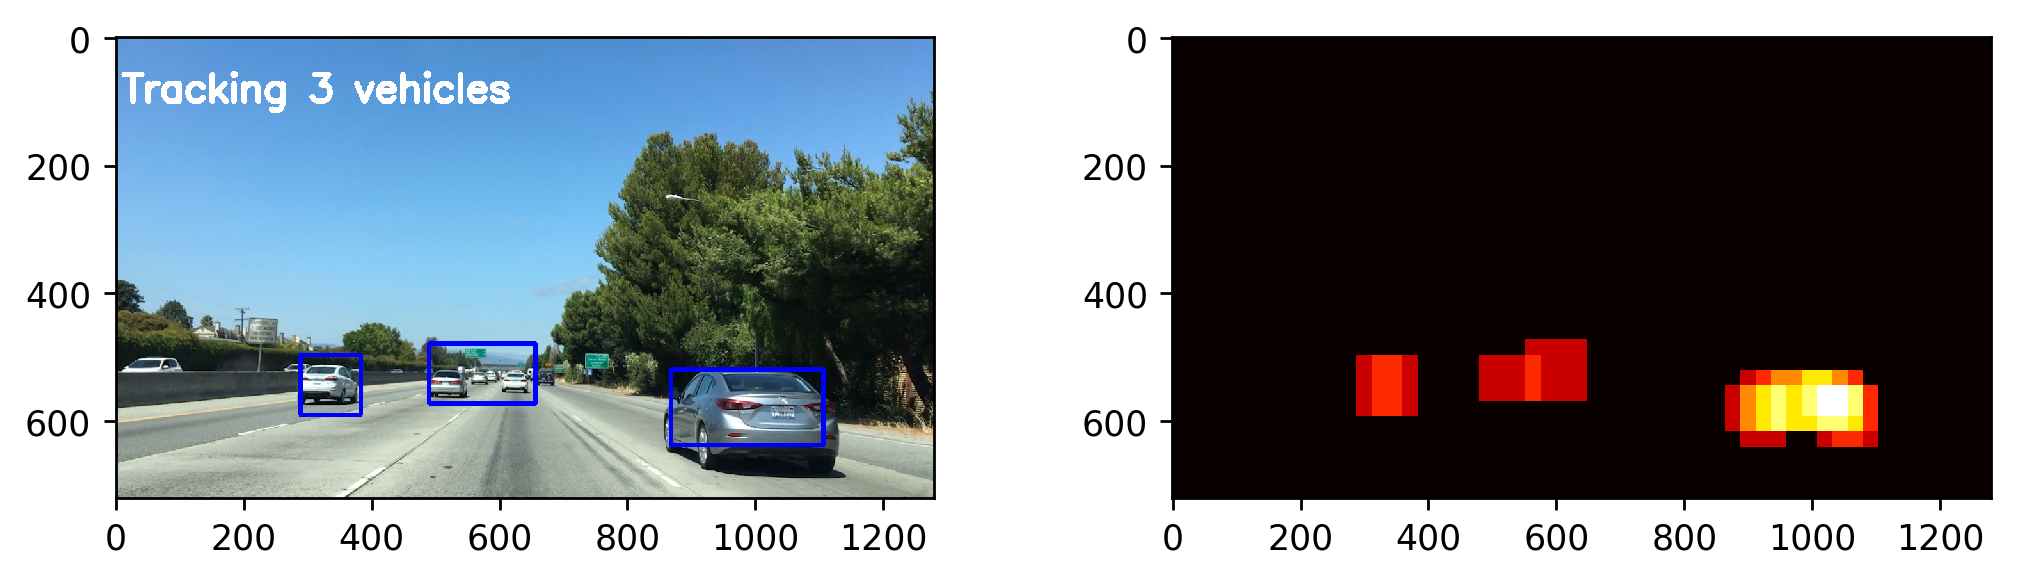

In [23]:
example_images = glob.glob('test_images/*jpg')
images=[]
titles=[]

ystart = 400
ystop = 656
scale=1.5

vt_image = VehicleTracking(ystart, ystop, scale, svc, X_scaler, spatial_params, hoc_params, hog_params)
vt_image.set_debug_mode('on')

for img_src in example_images:
    img = mpimg.imread(img_src)
    labeled_img = vt_image.pipeline(img)
    images.append(labeled_img)
    titles.append('')
    images.append(vt_image.heatmap)
    titles.append('')
    break

fig = plt.figure(figsize=(10,20), dpi=250)
visualise(fig, 7, 2, images, titles)

In [ ]:
test_video_frames = glob.glob('test_video_frames/*jpg')
images=[]
titles=[]

ystart = 400
ystop = 656
scale=1.5

vt_image = VehicleTracking(ystart, ystop, scale, svc, X_scaler, spatial_params, hoc_params, hog_params)
vt_image.set_debug_mode('on')
vt_image.process_video()

for img_src in sorted(test_video_frames, key=lambda a: int(a.split("\\")[1].split(".")[0].split("e")[1]) ):
    print('\n'+img_src)
    img = mpimg.imread(img_src)
    labeled_img = vt_image.pipeline(img)
    mpimg.imsave('test_video_frames_output/'+img_src.split("\\")[1], labeled_img)

In [ ]:
project_video_frames = glob.glob('project_video_frames/*jpg')
images=[]
titles=[]

ystart = 400
ystop = 656
scale=1.5

vt_pimage = VehicleTracking(ystart, ystop, scale, svc, X_scaler, spatial_params, hoc_params, hog_params)
vt_pimage.set_debug_mode('on')
vt_pimage.process_video()

for img_src in project_video_frames:
    print('\n'+img_src)
    img = mpimg.imread(img_src)
    labeled_img = vt_pimage.pipeline(img)
    mpimg.imsave('project_video_frames_output/'+img_src.split("\\")[1], labeled_img)